# Ground-roll attenuation model

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Hyperparameters estimation](#Hyperparameters-estimation)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, L, I
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files,
                            statistics_plot)
from seismicpro.models import FieldMetrics

Index field records:

In [2]:
path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy,1,/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy
111906,1657,36,2,/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy,2,/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy
111906,1655,78,3,/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy,3,/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy
111906,1658,79,4,/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy,4,/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy
111906,1654,127,5,/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy,5,/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy


Sample raw and target field record:

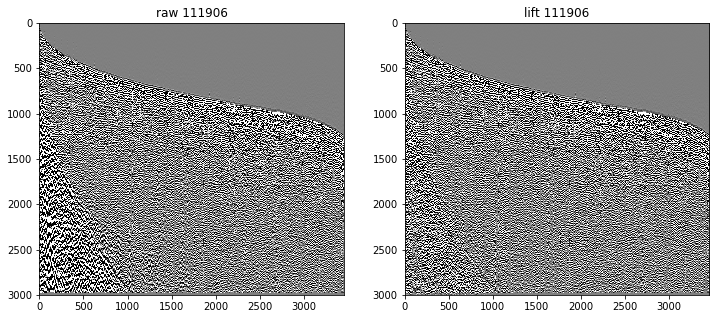

In [3]:
cv = 0.1
(Dataset(index, SeismicBatch).next_batch(1)
         .load(components=('raw', 'lift'), fmt='segy')
         .seismic_plot(('raw', 'lift'), index.indices[0],
                       figsize=(12, 5), vmin=-cv, vmax=cv, cmap='gray'))

Selecting field records and traces for model training:

In [4]:
train_index = index.create_subset(index.indices[:10])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 4 and the following config:

Layouts:
* encoder: Conv1d - Activation - Conv1d - Activation
* downsampling: MaxPooling1d - Dropout
* decoder: Conv1d - Activation - Conv1d - Activation
* upsampling: TransposedConv1d - Activation - Dropout

Convolutions (Conv1d, TransposedConv1d):
* ```filters``` = 16 * 2**i, i is a encoder (decoder) depth level, varies from 0 to 3.
* ```kernel_size``` = 7
* ```strides``` = 2
* ```padding``` = ```'same'```
* ```data_format``` = ```'channels_last'```
* ```activation``` = None

MaxPooling1d:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation:
* ```activation``` = ```tf.nn.elu```

Dropout:
* ```dropout_rate```=0.05

Setting the model config:

In [5]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [16, 32, 64, 128, 256],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss': 'l1',
    'optimizer': 'Adam'
}

## Hyperparameters estimation

See the [research notebook](https://github.com/analysiscenter/SeismicPro/blob/master/models/Ground-roll%20attenuation/parameters_estimation.ipynb) for investigation of ```filters``` and ```kernel_size``` influence on the model performance.

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.001

Loss fuction: ```l1```

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 3.

Setting a train pipeline:

In [6]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'x': exp_stack(batch.raw),
            'y': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss', mode='a'))
                 )

Run the training pipeline

In [7]:
batch_size = 16

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

100%|██████████| 6480/6480 [40:04<00:00,  2.69it/s]


Loss against iterations:

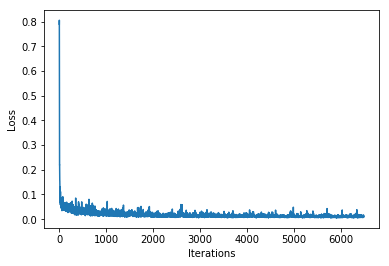

In [8]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Dump the model:

In [9]:
train_pipeline.save_model_now('unet', './unet_model')

## Inference

Imference pipeline:

In [10]:
model_config = {
    "build": False,
    "load/path": './unet_model'
}

def make_data(batch, **kwagrs):
    return {'x': exp_stack(batch.raw)}

dump_path = '/data/NA/dumps'

predict_pipeline = (Pipeline()
                    .load(components='raw', fmt='segy', tslice=np.arange(3000))
                    .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res')
                    .predict_model('unet', fetches='predictions', 
                                   make_data=make_data, save_to=V('raw'))
                    .dump(fmt='segy', path=L(lambda x: os.path.join(dump_path, str(x) + '.sgy'))(I()),
                          src='raw', split=False)
                   )

INFO:tensorflow:Restoring parameters from ./unet_model/model-6480


Run the pipeline on the whole dataset:

In [11]:
batch_size = 300
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

100%|██████████| 587/587 [20:06<00:00,  2.50s/it]


Merge dumped segy files into one:

In [12]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/data/NA/merged.sgy')

100%|██████████| 593/593 [00:53<00:00,  6.90it/s]


## Running time

System config:
* GPU: GTX GeForce 1080
* CPU(s): 40
* Model name: Intel Xeon E5-2630

Time performance:
* Single model training iteration with batch size=64: 0.17 sec.
* Inference of 1000 traces: 0.9 sec.

## Model evaluation

The [model estimation notebook](https://github.com/analysiscenter/SeismicPro/blob/master/models/Ground-roll%20attenuation/parameters_estimation.ipynb) demonstrates variability of `l1` metrics on the test dataset across multiple model initializations. The average (median) `l1` value is found to be 0.0064 with standard deviatin of 0.0004.

For detailed model evaluation we
* select sample test seismograms and compare signal power spectrum with tragest seismogram
* select sample test seismograms and consider statistics distribution over traces in time and frequency domain.

Inference pipeline for model evaluation:

In [13]:
def make_data(batch, **kwagrs):
    return {'x': exp_stack(batch.raw)}

predict_pipeline = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000),
                          fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res', mode='a'))
                   )

Select a sample seismogram from test part of the dataset:

In [14]:
i = 20
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

Run the inference pipeline on the test seismograms:

In [15]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=100, n_epochs=1, drop_last=False, shuffle=False, bar=True)

100%|██████████| 35/35 [00:23<00:00,  1.59it/s]


Arrange results:

In [16]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)
raw = np.vstack(np.concatenate(predict_pipeline.get_variable("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.get_variable("lift")))

### Visual estimation

Show raw traces, model output and difference between them:

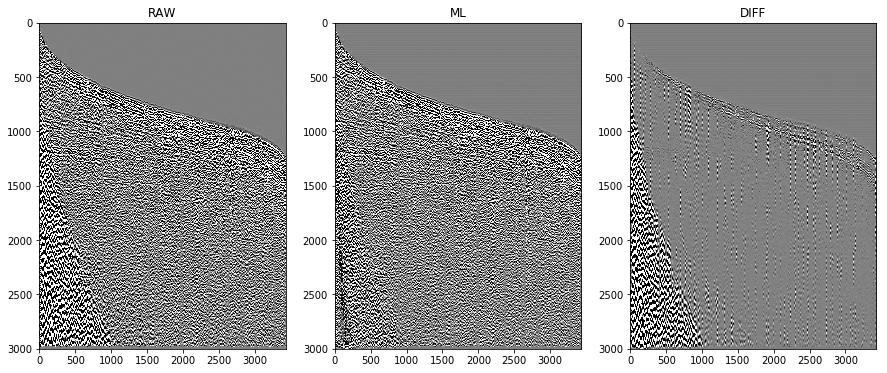

In [17]:
seismic_plot([raw, res, res - raw], names=['RAW', 'ML', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Show model output, traget seismogram difference between them:

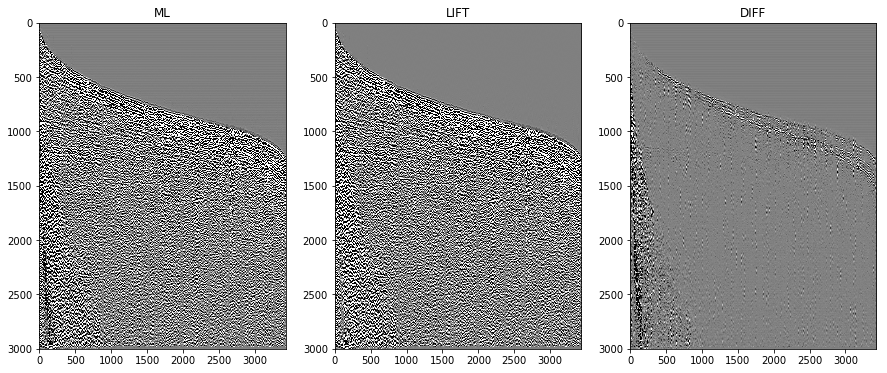

In [18]:
seismic_plot([res, lift, res - lift], names=['ML', 'LIFT', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

### MAE metrics

Estimate MAE between model output and target seismogram:

In [19]:
mtr = FieldMetrics(lift, res)
print('MAE:', mtr.mae())

MAE: 0.009450848


### Trace correlations

Get correlation coeffitiens between target traces and model output:

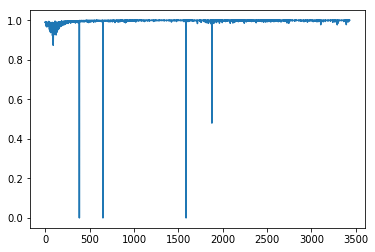

In [20]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
plt.show()

Note that zero correlation occurs due to zero traces in the dataset.

Average correlation is:

In [21]:
print('Averaged correlation:', mtr.corr_coef())

Averaged correlation: 0.9958263


### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

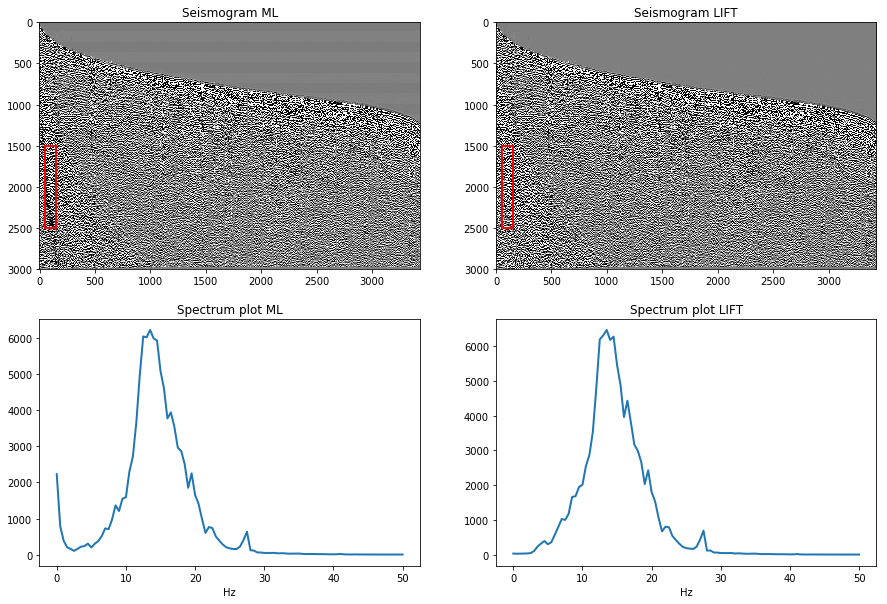

In [22]:
spectrum_plot([res, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['ML', 'LIFT'])

Power spectrum comparison out of ground-roll region:

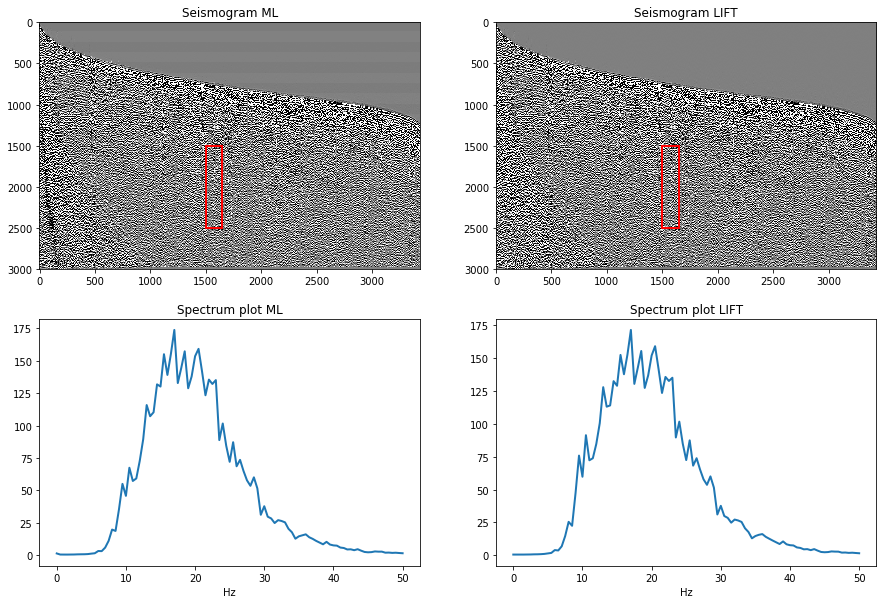

In [23]:
spectrum_plot([res, lift], frame=(slice(1500, 1650), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['ML', 'LIFT'])

### Trace statistics comparison

Comparison of rms amplitudes:

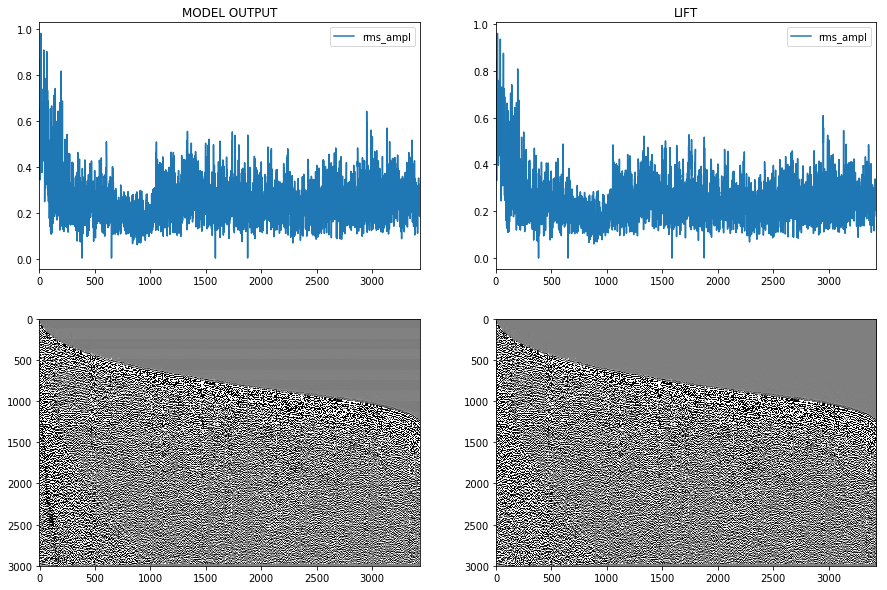

In [24]:
statistics_plot((res, lift), stats='rms_ampl', names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

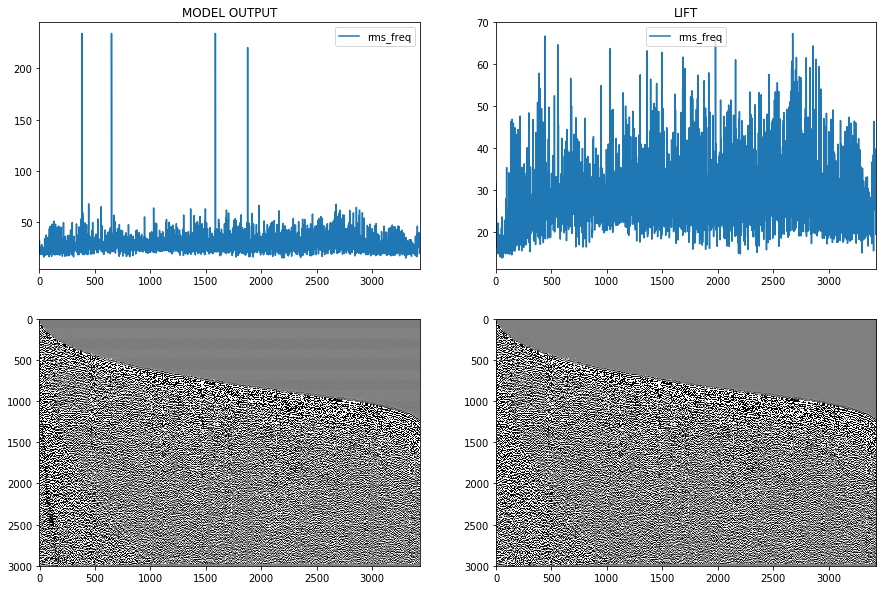

In [25]:
statistics_plot((res, lift), stats='rms_freq', rate=0.002,
                names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

## Criticism

The plots with trace statistics demonstrate outlier traces with e.g. increased dominant frequency. Such outliers may affect stacked seismogram. 

## Conclusion

The model reduces the ground-rol noise and shows similar to target power spectrum both in ground-roll region and outside it. However, we observe a number of outliers, e.g. traces with substantially increased dominant frequency and signal amptitudes. This is probably a manifestation of the 1D model architecture. Anyway, this effect is undesired for the processsed seismogram.

## Suggestions for improvements

Natural suggestion is to consider multychannel models that take into account neighbouring traces.